# Mashify
This notebook serves as a walkthrough of the mashify process.

In [1]:
import numpy as np
import librosa
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.stats import zscore
import demucs.separate
from ssmnet import core
import pandas as pd

from dataclasses import dataclass
from typing import List, Tuple
import os
import yaml
import IPython.display as ipd
import soundfile as sf
import math

import utils
import mashing_utils as mu

## Song Analysis Step:

Includes music attribute extraction (extracting key, tempo), music source separation (separating tracks into drums, bass, vocals, other), and music structure analysis (segmenting parts of a song into its intro, verse, chorus, etc.)

### Music Attribute Extraction:

Extracting the tempo:

In [4]:
def get_bpm(song_file: str):
    # Load the audio file
    y, sr = librosa.load(song_file)

    # Estimate the tempo (BPM)
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

    return tempo

song_path = "songs/cherry_wine.mp3" # your file name here
song_bpm = get_bpm(song_path)
print("The song's tempo in BPM is:", song_bpm)

The song's tempo in BPM is: 103.359375


Extracting the key:

Extracting chroma features...
Estimating key...
Predicted Keys:
1. E Minor (Confidence: 0.58)
2. B Minor (Confidence: 0.45)
3. E Major (Confidence: 0.45)


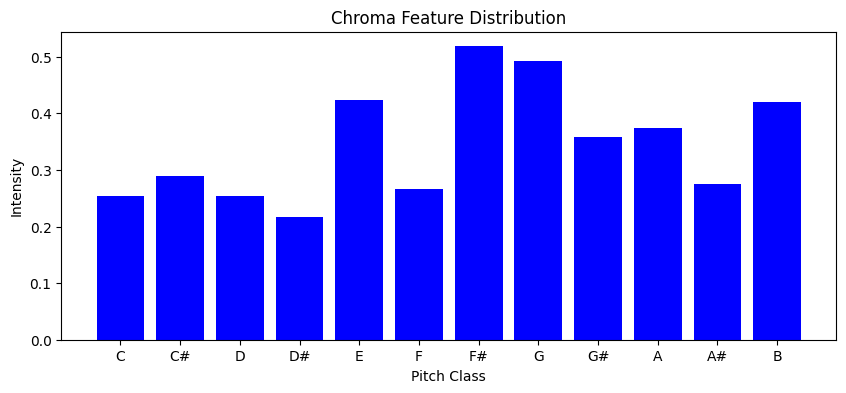

In [5]:
@dataclass
class KeyEstimator:
    """
    Estimates the musical key of a song based on chroma feature matching.
    """

    # Krumhansl-Schmuckler Key Profiles
    major_template = np.asarray(
        [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    )
    minor_template = np.asarray(
        [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
    )

    def __post_init__(self):
        # Normalize and create circulant matrices for template matching
        self.major_template = zscore(self.major_template)
        self.major_norm = scipy.linalg.norm(self.major_template)
        self.major_template = scipy.linalg.circulant(self.major_template)

        self.minor_template = zscore(self.minor_template)
        self.minor_norm = scipy.linalg.norm(self.minor_template)
        self.minor_template = scipy.linalg.circulant(self.minor_template)

    def estimate_key(self, chroma_vector: np.array, top_n: int = 3) -> List[Tuple[str, float]]:
        """
        Estimates the most likely keys from the given chroma vector.
        Returns the top `top_n` best-matching keys with confidence scores.
        """
        chroma_vector = zscore(chroma_vector)
        chroma_norm = scipy.linalg.norm(chroma_vector)

        # Compute similarity scores
        major_scores = self.major_template.T.dot(chroma_vector) / self.major_norm / chroma_norm
        minor_scores = self.minor_template.T.dot(chroma_vector) / self.minor_norm / chroma_norm

        key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

        # Create a sorted list of key matches with scores
        all_keys = []
        for i in range(12):
            all_keys.append((f"{key_names[i]} Major", major_scores[i]))
            all_keys.append((f"{key_names[i]} Minor", minor_scores[i]))

        # Sort by confidence score (highest first)
        all_keys = sorted(all_keys, key=lambda x: x[1], reverse=True)

        # Return top `top_n` possible keys
        return all_keys[:top_n]


def extract_chroma_features(song_path: str) -> np.array:
    """
    Extracts chroma features from an audio file.
    Uses Harmonic-Percussive Source Separation (HPSS) for better accuracy.
    """
    y, sr = librosa.load(song_path, sr=None)  # Load audio file

    # Apply Harmonic-Percussive Source Separation (HPSS)
    harmonic, _ = librosa.effects.hpss(y)

    # Extract chroma features using Constant-Q Transform (CQT)
    chroma = librosa.feature.chroma_cqt(y=harmonic, sr=sr)

    # Compute the mean chroma vector over the entire song
    avg_chroma = np.mean(chroma, axis=1)

    return avg_chroma

def plot_chroma(chroma_vector: np.array):
    """
    Plots the chroma feature vector for visualization.
    """
    key_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    plt.figure(figsize=(10, 4))
    plt.bar(key_labels, chroma_vector, color='blue')
    plt.xlabel("Pitch Class")
    plt.ylabel("Intensity")
    plt.title("Chroma Feature Distribution")
    plt.show()


# ====== Example Usage ======
song_path = "songs/cherry_wine.mp3"  # your file name here

print("Extracting chroma features...")
chroma_vector = extract_chroma_features(song_path)

print("Estimating key...")
estimator = KeyEstimator()
top_keys = estimator.estimate_key(chroma_vector, top_n=3)

print("Predicted Keys:")
for i, (key, score) in enumerate(top_keys):
    print(f"{i+1}. {key} (Confidence: {score:.2f})")

# Plot chroma feature distribution
plot_chroma(chroma_vector)

### Music Source Separation:

In [6]:
def isolate_song_parts(song_filepath: str):
    """
    Separates the given song into vocals and instrumental parts using Demucs.

    Args:
        song_filepath (str): Path to the input song file.

    Raises:
        FileNotFoundError: If the song file does not exist.
        ValueError: If the file extension is not supported.
        RuntimeError: For any errors during the separation process.
    """
    try:
        # Check if the file exists
        if not os.path.isfile(song_filepath):
            raise FileNotFoundError(f"File not found: {song_filepath}")
        
        # Check if the file is an MP3 (or other supported format)
        valid_extensions = {".mp3", ".wav", ".flac", ".ogg"}
        _, ext = os.path.splitext(song_filepath)
        if ext.lower() not in valid_extensions:
            raise ValueError(f"Unsupported file format '{ext}'. Supported formats are: {', '.join(valid_extensions)}")
        
        # Run Demucs separation
        print(f"Processing file: {song_filepath}")
        demucs.separate.main(["--mp3", "-n", "htdemucs", song_filepath]) # using the htdemucs model
        print("Separation completed successfully.")

        song_name = song_filepath.replace(".mp3", "")
        return(f"separated/htdemucs/{song_name}/vocals.mp3", f"separated/htdemucs/{song_name}/other.mp3", 
               f"separated/htdemucs/{song_name}/bass.mp3", f"separated/htdemucs/{song_name}/drums.mp3")

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
    except ValueError as val_error:
        print(f"Error: {val_error}")
    except Exception as e:
        # Catch-all for unexpected errors
        print(f"An unexpected error occurred: {e}")
        raise RuntimeError("Demucs processing failed.") from e
    return (None, None)

song_path = "songs/cherry_wine.mp3" # your file name here
separated_track_paths = isolate_song_parts(song_path)
print("The separated tracks are located at: ", separated_track_paths)

Processing file: songs/cherry_wine.mp3
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in C:\Users\Jimmy\Desktop\Uni\Fourth Year Uni\SPRING 2025\CSC 475\Repo\Mashify\separated\htdemucs
Separating track songs\cherry_wine.mp3


100%|████████████████████████████████████████████████████████████████████████| 175.5/175.5 [01:12<00:00,  2.41seconds/s]


Separation completed successfully.
The separated tracks are located at:  ('separated/htdemucs/songs/cherry_wine/vocals.mp3', 'separated/htdemucs/songs/cherry_wine/other.mp3', 'separated/htdemucs/songs/cherry_wine/bass.mp3', 'separated/htdemucs/songs/cherry_wine/drums.mp3')


### Music Structure Analysis:

c:\Users\Jimmy\anaconda3\envs\mashtest\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


The segmentation outputs are located at: ./ssmnet_outputs/cherry_wine/cherry_wine_output_pdf.pdf, ./ssmnet_outputs/cherry_wine/cherry_wine_output_csv.csv


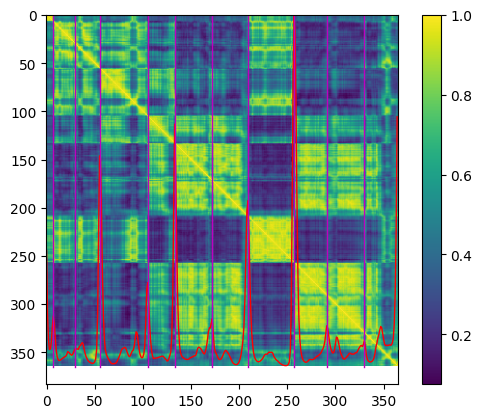

In [7]:
# code modified from https://github.com/geoffroypeeters/ssmnet_ISMIR2023

def label_segment_boundaries(config_file: str, audio_file: str) -> Tuple[str, str]:
    """
    Labels the song's segment boundaries.

    Args:
        config_file (str): Path to the configuration file used for the model.
        audio_file (str): Path to the audio file to segment.

    Returns:
        tuple (output_pdf_file, output_csv_file)
        where
            output_pdf_file (str): Path to the pdf output graph
            output_csv_file (str): Path to the csv output containing the song's segment boundaries
    """
    song_name = os.path.splitext(os.path.basename(audio_file))[0]
    os.makedirs("ssmnet_outputs/" + song_name, exist_ok=True) 

    output_pdf_file = "./ssmnet_outputs/" + song_name + "/" + song_name + "_output_pdf.pdf"
    output_csv_file = "./ssmnet_outputs/" + song_name + "/" + song_name + "_output_csv.csv"

    with open(config_file, "r", encoding="utf-8") as fid:
        config_d = yaml.safe_load(fid)

    ssmnet_deploy = core.SsmNetDeploy(config_d)

    # get the audio features patches
    feat_3m, time_sec_v = ssmnet_deploy.m_get_features(audio_file)
    # process through SSMNet to get the Self-Similarity-Matrix and Novelty-Curve
    hat_ssm_np, hat_novelty_np = ssmnet_deploy.m_get_ssm_novelty(feat_3m)
    # estimate segment boundries from the Novelty-Curve
    hat_boundary_sec_v, hat_boundary_frame_v = ssmnet_deploy.m_get_boundaries(hat_novelty_np, time_sec_v)

    # export as .pdf
    ssmnet_deploy.m_plot(hat_ssm_np, hat_novelty_np, hat_boundary_frame_v, output_pdf_file)
    # export as .csv
    ssmnet_deploy.m_export_csv(hat_boundary_sec_v, output_csv_file)

    return (output_pdf_file, output_csv_file)

config_file = "./config.yaml"
audio_file = "./songs/cherry_wine.mp3"
(segment_pdf, segment_csv) = label_segment_boundaries(config_file, audio_file)
print("The segmentation outputs are located at: " + segment_pdf + ", " + segment_csv)

### Writing audio files of the song's segments

In [8]:
def segment_in_samples(segments: List, sr: int) -> List:
    """
    Helper function that converts segments in time to segments in samples.

    Args:
        segments (list): List of song segment times.
        sr (int): Sample rate of the song.

    Returns:
        segment_samples (list): List of the song's segments in samples.
    """
    segments_samples = []

    for time in segments:
        sample_num = int(time * sr)
        segments_samples.append(sample_num)

    return segments_samples

def write_segments(song: str, segment_csv: str) -> str:
    """
    Writes audio files for each song's segments. Each audio file is 
    named segment{i} where i is the segment's number.

    Args:
        song (str): Path to the song file used.
        segment_csv (str): Path to the csv file containing the song's segments in times.

    Returns:
        segment_dir (str): Path to the audio files of the segments.
    """
    song_name = os.path.splitext(os.path.basename(song))[0]
    segment_dir = "song_segments/" + song_name + "/"
    os.makedirs(segment_dir, exist_ok=True)

    # get segment times from the output csv using pandas
    song_segments = pd.read_csv(segment_csv)
    song_seg_times = song_segments['segment_start_time_sec']

    # load with librosa
    (song_samples, srate) = librosa.load(song)
    # ipd.Audio(song_samples, rate=srate1)

    song_seg_samples = segment_in_samples(song_seg_times, srate)

    # test segments
    # print(song_seg_samples)
    # ipd.Audio(song1[song1_seg_samples[11]:], rate=srate1)
    # sf.write("segtest.mp3", song1[song1_seg_samples[11]:], srate1)

    # write an audio file for each segment (i.e. song_segments/song_name/segment1.mp3)
    for (i,seg) in enumerate(song_seg_samples):
        # handle last case
        if (i == (len(song_seg_samples) - 1)):
            current_seg = song_samples[seg:]
        else:
            current_seg = song_samples[song_seg_samples[i]:song_seg_samples[i+1]]
        sf.write(f"song_segments/{song_name}/segment{i+1}.mp3", current_seg, srate)
    
    return segment_dir

song1 = "./songs/cherry_wine.mp3"
segment_files = write_segments(song1, segment_csv)

## Mashing Step:

Includes matching key and tempo, and mashup generation

### Matching Keys

In [43]:
# find keys of both songs

song_path1 = "songs/cherry_wine.mp3"
song_path2 = "songs/perfect_pair.mp3" 

print("Extracting chroma features...")
chroma_vector1 = extract_chroma_features(song_path1)
chroma_vector2 = extract_chroma_features(song_path2)

print("Estimating key...")
estimator = KeyEstimator()
top_keys1 = estimator.estimate_key(chroma_vector1, top_n=3)
top_keys2 = estimator.estimate_key(chroma_vector2, top_n=3)

Extracting chroma features...
Estimating key...


In [ ]:
def match_keys(song1_key: str, song2_key: str, song1_samples: np.ndarray, sr1: np.number, song2_samples: np.ndarray, sr2: np.number) -> Tuple[str, str]:
    """
    Takes the average of two song's keys and pitches each of them to match that average.
    Favours pitching up over pitching down (e.g. if the song 1 is in A, and song 2 is in A#,
    song 1 is pitched up to A#). Writes files of the pitched songs and returns a path to them.

    Args:
        song1_key (str): Key of song 1 in string format e.g. "A#".
        song2_key (str): Key of song 2 in string format e.g. "A#".
        song1_samples (np.ndarray): Song 1 in samples loaded through librosa with librosa.load().
        sr1 (np.number): Song 1's sample rate.
        song2_samples (np.ndarray): Song 2 in samples loaded through librosa with librosa.load().
        sr2 (np.number): Song 2's sample rate.

    Returns:
        Tuple[str, str]: Path to the two songs after their keys have been matched.
    """
    note_to_midi = {
            "C": 0, "C#": 1, "Db": 1, "D": 2, "D#": 3, "Eb": 3, "E": 4, "F": 5, 
            "F#": 6, "Gb": 6, "G": 7, "G#": 8, "Ab": 8, "A": 9, "A#": 10, "Bb": 10, "B": 11
        }

    song1_key_val = note_to_midi[song1_key]
    song2_key_val = note_to_midi[song2_key]

    print(f"Song 1's key: {song1_key} ({song1_key_val} in MIDI)")
    print(f"Song 2's key: {song2_key} ({song2_key_val} in MIDI)")

    key_diff = song2_key_val - song1_key_val

    print(f"The difference between the keys is: {key_diff}")

    if(key_diff < 0):
        key_diff = key_diff + 12

    song1_shift = 0
    song2_shift = 0

    if(key_diff <=6):
        if((key_diff % 2) == 0):
            song1_shift = int(key_diff/2)
            song2_shift = -(song1_shift)
        else:
            song1_shift = math.ceil(key_diff/2)
            song2_shift = -(song1_shift - 1)
    else:
        key_diff = abs(key_diff - 12)
        if((key_diff % 2) == 0):
            song2_shift = int(key_diff/2)
            song1_shift = -(song2_shift)
        else:
            song2_shift = math.ceil(key_diff/2)
            song1_shift = -(song2_shift - 1)

    print("Song 1 key shift:", song1_shift)
    print("Song 2 key shift:", song2_shift)

    pitched_dir = "./songs_pitched/"

    os.makedirs(pitched_dir, exist_ok=True)

    song1_pitched_dir = pitched_dir + "song1_pitched.mp3"
    song2_pitched_dir = pitched_dir + "song2_pitched.mp3"

    song1_pitch_shifted = librosa.effects.pitch_shift(y=song1_samples, sr=sr1, n_steps=song1_shift)
    sf.write(song1_pitched_dir, song1_pitch_shifted, sr1)

    song2_pitch_shifted = librosa.effects.pitch_shift(y=song2_samples, sr=sr2, n_steps=song2_shift)
    sf.write(song2_pitched_dir, song2_pitch_shifted, sr2)

    return (song1_pitched_dir, song2_pitched_dir)

song1_key = top_keys1[0][0].split(" ")[0]
(song1_samples, sr1) = librosa.load(song_path1)

song2_key = top_keys2[0][0].split(" ")[0]
(song2_samples, sr2) = librosa.load(song_path2)

(song1_pitched_dir, song2_pitched_dir) = match_keys(song1_key, song2_key, song1_samples, sr1, song2_samples, sr2)
print("The pitched songs with matched keys are located at: ", song1_pitched_dir, song2_pitched_dir)

Song 1's key: E (4 in MIDI)
Song 2's key: B (11 in MIDI)
The difference between the keys is: 7
Song 1 key shift: -2
Song 2 key shift: 3
The pitched songs with matched keys are located at:  ./songs_pitched/song1_pitched.mp3 ./songs_pitched/song2_pitched.mp3


### Matching Tempo

In [47]:
def match_bpm(song_path1: str, song_path2:str, song1_samples: np.ndarray, sr1: np.number, song2_samples: np.ndarray, sr2: np.number, use_avg=False) -> Tuple[str, str]:
    """
    Matches two songs' tempos, writes files of the stretched songs, and returns a path to them.
    Can choose between using the average BPM by setting "use_avg" to True, or matches the slower
    song to the faster song if left as False.

    Args:
        song1_path (str): Path to song 1's audio file.
        song2_path (str): Path to song 2's audio file.
        song1_samples (np.ndarray): Song 1 in samples loaded through librosa with librosa.load().
        sr1 (np.number): Song 1's sample rate.
        song2_samples (np.ndarray): Song 2 in samples loaded through librosa with librosa.load().
        sr2 (np.number): Song 2's sample rate.

    Returns:
        Tuple[str, str]: Path to the two songs after their tempos have been matched.
    """
    song1_bpm = get_bpm(song_path1)
    print("Song 1's BPM:", song1_bpm)

    song2_bpm = get_bpm(song_path2)
    print("Song 2's BPM:", song2_bpm)

    if use_avg:
        print("Target BPM set to be the average of the two songs.")
        target_bpm = (song1_bpm + song2_bpm)/2
    else:
        # make target be the bpm of the faster song
        print("Target BPM set to be the BPM of the faster song.")
        target_bpm = max(song1_bpm, song2_bpm)

    song1_factor = target_bpm/song1_bpm
    song2_factor = target_bpm/song2_bpm
    print(f"The target BPM is {target_bpm}. Stretching song 1 by {song1_factor}, and song 2 by {song2_factor}")

    stretched_dir = "./songs_stretched/"

    os.makedirs(stretched_dir, exist_ok=True)

    song1_stretched_dir = stretched_dir + "song1_stretched.mp3"
    song2_stretched_dir = stretched_dir + "song2_stretched.mp3"

    song1_stretched = librosa.effects.time_stretch(song1_samples, rate=song1_factor)
    sf.write(song1_stretched_dir, song1_stretched, sr1)
    song2_stretched = librosa.effects.time_stretch(song2_samples, rate=song2_factor)
    sf.write(song2_stretched_dir, song2_stretched, sr2)

    return (song1_stretched_dir, song2_stretched_dir)

# song_path1 = "songs/cherry_wine.mp3"
# song_path2 = "songs/perfect_pair.mp3"

song_path1 = song1_pitched_dir
song_path2 = song2_pitched_dir
(song1_samples, sr1) = librosa.load(song1_pitched_dir)
(song2_samples, sr2) = librosa.load(song2_pitched_dir)

(song1_stretched_dir, song2_stretched_dir) = match_bpm(song_path1, song_path2, song1_samples, sr1, song2_samples, sr2, use_avg=False)
print("The stretched songs with matched bpm are located at: ", song1_stretched_dir, song2_stretched_dir)

Song 1's BPM: 103.359375
Song 2's BPM: 143.5546875
Target BPM set to be the BPM of the faster song.
The target BPM is 143.5546875. Stretching song 1 by 1.3888888888888888, and song 2 by 1.0
The stretched songs with matched bpm are located at:  ./songs_stretched/song1_stretched.mp3 ./songs_stretched/song2_stretched.mp3


### Writing segmented audio files for each of the pitched and stretched songs

Labeling the segment boundaries for song 1...
The segmentation outputs for song 1 are located at: ./ssmnet_outputs/song1_stretched/song1_stretched_output_pdf.pdf, ./ssmnet_outputs/song1_stretched/song1_stretched_output_csv.csv
Labeling the segment boundaries for song 2...
The segmentation outputs for song 2 are located at: ./ssmnet_outputs/song2_stretched/song2_stretched_output_pdf.pdf, ./ssmnet_outputs/song2_stretched/song2_stretched_output_csv.csv
Writing audio files for each of song 1's segments...
The audio files of song 1's segments are located at:  song_segments/song1_stretched/
Writing audio files for each of song 2's segments...
The audio files of song 2's segments are located at:  song_segments/song2_stretched/


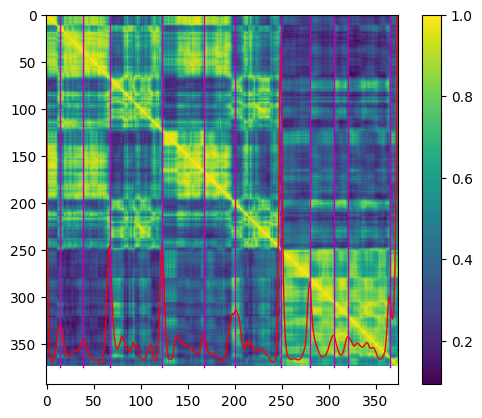

In [ ]:
VOCAL_SEGMENT = False

if(VOCAL_SEGMENT):
    # segment based on extracted vocals to not cut off the lyrics
    print("Segmenting based on vocals...")

    print("Separating the tracks of song 1...")
    separated_track1_paths = isolate_song_parts(song1_stretched_dir)
    print("The separated tracks are located at: ", separated_track1_paths)

    song1_dir = separated_track1_paths[0] # vocals

    print("Separating the tracks of song 2...")
    separated_track2_paths = isolate_song_parts(song2_stretched_dir)
    print("The separated tracks are located at: ", separated_track2_paths)

    song2_dir = separated_track2_paths[0]
else:
    song1_dir = song1_stretched_dir
    song2_dir = song2_stretched_dir

print("Labeling the segment boundaries for song 1...")
(segment_pdf1, segment_csv1) = label_segment_boundaries(config_file, song1_dir)
# print("The segmentation outputs for song 1 are located at: " + segment_pdf1 + ", " + segment_csv1)

print("Writing audio files for each of song 1's segments...")
segment_files1 = write_segments(song1_stretched_dir, segment_csv1)
print("The audio files of song 1's segments are located at: ", segment_files1)

print("Labeling the segment boundaries for song 2...")
(segment_pdf2, segment_csv2) = label_segment_boundaries(config_file, song2_dir)
# print("The segmentation outputs for song 2 are located at: " + segment_pdf2 + ", " + segment_csv2)

print("Writing audio files for each of song 2's segments...")
segment_files2 = write_segments(song2_stretched_dir, segment_csv2)
print("The audio files of song 2's segments are located at: ", segment_files2)

### Mashup Generation

In [10]:
segment_files2 = "./song_segments/song1_stretched/"
segment_files1 = "./song_segments/song2_stretched/"

import numpy as np
import librosa
import soundfile as sf
import utils

def crossfade_segments(seg1: np.ndarray, seg2: np.ndarray, sr: np.number, fade_duration=0.5) -> np.ndarray:
    """
    Crossfades two audio segments by a certain given fade duration (seconds)

    Args:
        seg1 (np.ndrray): Segment 1 in samples.
        seg2 (np.ndarray): Segment 2 in samples.
        sr (np.number): Audio's sample rate.
        fade_duration (float): length of crossfade. Defaults to 0.5 if not specified.

    Returns:
        np.ndarray: Combined segments with the crossfade.
    """
    fade_len = int(sr * fade_duration)
    
    if len(seg1) < fade_len or len(seg2) < fade_len:
        raise ValueError("Segment too short for crossfade")

    fade_out = np.linspace(1, 0, fade_len)
    fade_in = np.linspace(0, 1, fade_len)

    seg1_end = seg1[-fade_len:] * fade_out
    seg2_start = seg2[:fade_len] * fade_in

    overlapped = seg1_end + seg2_start
    combined = np.hstack((seg1[:-fade_len], overlapped, seg2[fade_len:]))
    return combined

def apply_fade_out(audio: np.ndarray, sr: np.number, fade_duration=2.0):
    """
    Applies a fade out by a certain given duration (seconds)

    Args:
        audio (np.ndrray): Audio to fade in samples.
        sr (np.number): Audio's sample rate.
        fade_duration (float): Length of fade. Defaults to 2.0 if not specified.

    Returns:
        np.ndarray: Segment with fade out applied.
    """
    fade_len = int(sr * fade_duration)
    if len(audio) < fade_len:
        fade_len = len(audio)
    fade_curve = np.linspace(1.0, 0.0, fade_len)
    audio[-fade_len:] *= fade_curve
    return audio

def generate_mashup(segment_files1: str, segment_files2: str):
    """
    Algorithmically produces a mashup which follows the following song structure:
        Intro of song A, Verse of song A, Verse of song B, Chorus of song B, Chorus of song A
    Writes an output file named "mash.mp3"

    Assumes that the two songs given have corresponding segments that match with a song's structure as folllows:
        Segment 1: Intro, Segments 2-3: Verse, Segments 4-5: Chorus

    Args:
        segment1_files (str): Filepath to the audio file segments of song 1.
        segment2_files (str): Filepath to the audio file segments of song 2.
    """
    segments1 = utils.get_all_filepaths_sorted(segment_files1)
    segments2 = utils.get_all_filepaths_sorted(segment_files2)

    # Assume the following structure:
    # segment 1: intro
    # segments 2-3: verse
    # segments 4-5: chorus
    sr = None

    introA, sr = librosa.load(segments1[0], sr=None)
    verseA1, _ = librosa.load(segments1[1], sr=sr)
    verseA2, _ = librosa.load(segments1[2], sr=sr)
    chorusA1, _ = librosa.load(segments1[3], sr=sr)
    chorusA2, _ = librosa.load(segments1[4], sr=sr)

    verseB1, _ = librosa.load(segments2[1], sr=sr)
    verseB2, _ = librosa.load(segments2[2], sr=sr)
    chorusB1, _ = librosa.load(segments2[3], sr=sr)
    chorusB2, _ = librosa.load(segments2[4], sr=sr)

    # Combine with crossfades between A and B sections
    result = introA
    result = np.hstack((result, verseA1)) # np.hstack((result, verseA1, verseA2))

    result = crossfade_segments(result, verseB2, sr) # crossfade_segments(result, verseB1, sr)
    result = np.hstack((result, chorusB1)) # np.hstack((result, verseB2, chorusB1, chorusB2))

    result = crossfade_segments(result, chorusA2, sr)
    # result = np.hstack((result, chorusA2))

    # Apply fade-out to the final section
    result = apply_fade_out(result, sr, fade_duration=2.0)

    sf.write("mash.mp3", result, sr)
    print("Mashup saved as mash.mp3")

generate_mashup(segment_files1, segment_files2)

Mashup saved as mash.mp3


## Evaluation Step: